In [18]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


In [39]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [51]:
data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28619 non-null  object
 1   label   28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [22]:
data_tweets = pd.read_csv("../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [23]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [24]:
data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


Set News Headlines dataset variables

In [52]:
subset_size = len(data_news_headlines.index)
testing_size = int(subset_size * 0.2)
validation_size = testing_size
shuffle_size = subset_size - validation_size

data_batch_size = 32

Shuffle the data and set the train and test splits

In [53]:
data = data_news_headlines.sample(frac=1).reset_index(drop=True)
train_data = data.head(subset_size - testing_size)
test_data = data.tail(testing_size)

In [54]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][validation_size:], 
        train_data['label'][validation_size:]
    )
).shuffle(shuffle_size).batch(data_batch_size)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][:validation_size],
        train_data['label'][:validation_size]
    )
).batch(data_batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
        test_data['text'],
        test_data['label']
    )
)

text_vocab_ds = tf.data.Dataset.from_tensor_slices(train_data['text'])

Set training variables

In [55]:
epochs = 400

##define the parameters for tokenizing and padding
vocab_size = 10000
embedding_dim = 32
max_length = 120

Create the text vectorization layer and create the vocab

In [56]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize='lower_and_strip_punctuation', split='whitespace', output_mode='int', output_sequence_length=max_length)

vectorize_layer.adapt(text_vocab_ds.batch(data_batch_size))

Create the Model

In [57]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_12 (Text  (None, 120)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 120, 32)           320000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 120, 256)         164864    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                      

Train the model

In [58]:
history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs)

Epoch 1/400
537/537 [==============================] - 89s 166ms/step - loss: 0.4151 - accuracy: 0.7950 - val_loss: 0.3300 - val_accuracy: 0.8508
Epoch 2/400
537/537 [==============================] - 89s 166ms/step - loss: 0.2170 - accuracy: 0.9145 - val_loss: 0.3313 - val_accuracy: 0.8562
Epoch 3/400
537/537 [==============================] - 88s 164ms/step - loss: 0.1316 - accuracy: 0.9521 - val_loss: 0.4175 - val_accuracy: 0.8499
Epoch 4/400
537/537 [==============================] - 87s 162ms/step - loss: 0.0770 - accuracy: 0.9736 - val_loss: 0.4944 - val_accuracy: 0.8440
Epoch 5/400
537/537 [==============================] - 85s 159ms/step - loss: 0.0504 - accuracy: 0.9831 - val_loss: 0.5889 - val_accuracy: 0.8462
Epoch 6/400
537/537 [==============================] - 85s 158ms/step - loss: 0.0306 - accuracy: 0.9913 - val_loss: 0.7750 - val_accuracy: 0.8420
Epoch 7/400
537/537 [==============================] - 85s 158ms/step - loss: 0.0244 - accuracy: 0.9924 - val_loss: 0.8811 -

Test the model

In [62]:
loss, accuracy = model.evaluate(test_ds.batch(32))

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

179/179 [==============================] - 13s 71ms/step - loss: 3.2648 - accuracy: 0.8099
Loss: 3.2647650241851807
Accuracy: 0.8098899126052856


Plot the accuracy and loss over time

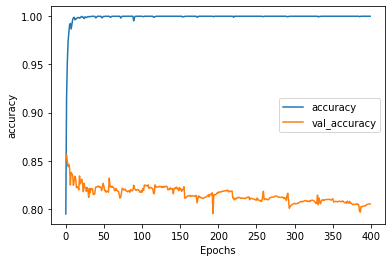

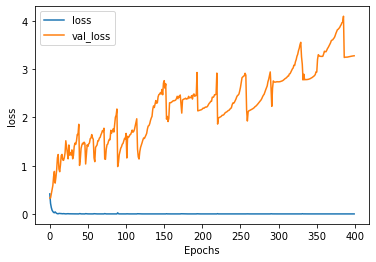

In [60]:
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

Export for inference

In [61]:
saved_model_path = './model_saves/lstm_v2/'
model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_saves/lstm_v2/assets


INFO:tensorflow:Assets written to: ./model_saves/lstm_v2/assets


Reload and test inference

In [63]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [64]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: ', inputs[i], ' : score: ', results.numpy()[i][0], ' : rounded: ', round(results.numpy()[i][0]))
  print()


examples = [
    "Please, keep talking. I always yawn when I am interested.", # expect 1
    "Well, what a surprise.", # expect 1
    "Really, Sherlock? No! You are clever.", # expect 1
    "The quick brown fox jumps over the lazy dog", # expect 0
    "Numerous references to the phrase have occurred in movies, television, and books." # expect 0
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.73105854  : rounded:  1
input:  Well, what a surprise.  : score:  0.5  : rounded:  0
input:  Really, Sherlock? No! You are clever.  : score:  0.50000304  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.5  : rounded:  0
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.5  : rounded:  0

Results from the model in memory:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.73105854  : rounded:  1
input:  Well, what a surprise.  : score:  0.5  : rounded:  0
input:  Really, Sherlock? No! You are clever.  : score:  0.50000304  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.5  : rounded:  0
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.5  : rounded:  0

